# Customised advice


In [1]:
#from matplotlib import rcParams
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
#from nilmtk.disaggregate import CombinatorialOptimisation

import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dred = DataSet('../data/DRED.h5')

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Opening ../data/DRED.h5 in read-only mode


/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## Plot PV generation and total energy use
The two lists below contain test data of PV generation and total energy use. By plotting the two lists over each other it becomes visible how a lot of the energy is used in periods where there is little or no energy generation.

In [2]:
pv_test_data = [0.0, 0.0, 0.0, 0.0, 0.0, 12.713, 214.371, 737.432, 1410.714, 2039.156, 2452.865, 2729.085, 2792.666, 2673.155, 2365.469, 1821.737, 1121.648, 454.233, 104.846, 0.0, 0.0, 0.0, 0.0, 0.0]
energy_test_data = [0.0, 21.0, 25.0, 523.0, 521.0, 1345.713, 1234.371, 37.432, 510.714, 539.156, 452.865, 729.085, 722.666, 73.155, 65.469, 821.737, 921.648, 1454.233, 1024.846, 1234.0, 876.0, 533.0, 234.0, 4.0]

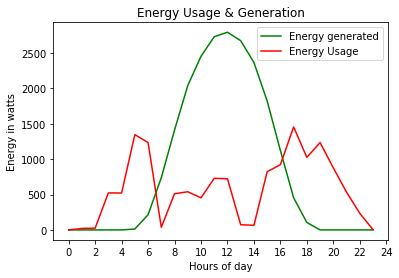

In [3]:
plt.plot(pv_test_data, 'g', label="Energy generated")
plt.plot(energy_test_data, 'r', label="Energy Usage")

yaxis_height= 3000
yaxis_depth = 0
tx = np.arange(0, 24, 0.2)
plt.ylabel('Energy in watts')
plt.legend(loc='upper right')
plt.xlabel("Hours of day")
plt.title('Energy Usage & Generation')
plt.xticks(np.arange(min(tx), max(tx) + 1, 2))

plt.show()

## Subtracting lists
Below it the two lists are subtracted from each other. By doing this it becomes visible at what times there is a possitive energy output and when there is a negative energy output. Positive meaning more energy being generated than used and negative meaning the opposite.

In [4]:
opportunities = []
for pv, used in zip(pv_test_data, energy_test_data):
    watts = pv - used
    opportunities.append(watts)

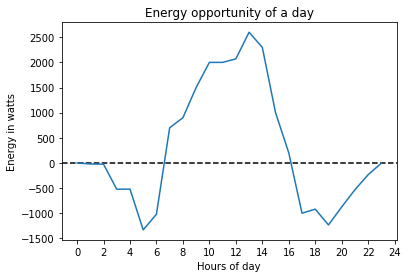

In [5]:
plt.axhline(color='black', linestyle='--')
plt.plot(opportunities)
tx = np.arange(0, 24, 0.2)
plt.ylabel('Energy in watts')
plt.xlabel("Hours of day")
plt.title('Energy opportunity of a day')
plt.xticks(np.arange(min(tx), max(tx) + 1, 2))

plt.show()

## List of opportunity times
In order to schedule better times for appliance use we'll make a list with desired appliance time ranges. The list will be two dimensional. Each item will contain a start and an end time.

In [6]:
from datetime import time

opportunity_found = False
opportunity_times = []
start_time = -1
end_time = -1
for opportunity in opportunities:   
    if opportunity > 0.0 and opportunity_found == False:
        start_time = time(opportunities.index(opportunity))
        opportunity_found = True
    elif opportunity <= 0.0 and opportunity_found == True:
        end_time = time(opportunities.index(opportunity) - 1)
        opportunity_times.append([start_time, end_time])
        opportunity_found = False
        
print(opportunity_times)

[[datetime.time(7, 0), datetime.time(16, 0)]]


## Check if appliance is used in opportunity times
To reschedule first the application has to know if the appliance is used within the opportunity times. We are going to use the washing machine as an example. The graph below depicts the use of the washing machine on one day.

In [22]:
%matplotlib inline

dred.set_window(start="10-18-2015", end="10-19-2015")

data = dred.buildings[1].elec
washing_machine = data['washing machine']

#washing_machine.plot()
washing_resampled = washing_machine.load().__next__()
washing_resampled.resample('H').mean()
#washing_machine.available_columns()

,power
,apparent
2015-10-18 00:00:00+02:00,0.950000
2015-10-18 01:00:00+02:00,0.950000
2015-10-18 02:00:00+02:00,0.950000
2015-10-18 03:00:00+02:00,0.950000
2015-10-18 04:00:00+02:00,0.950000
2015-10-18 05:00:00+02:00,0.950000
2015-10-18 06:00:00+02:00,0.950000
2015-10-18 07:00:00+02:00,0.950000
2015-10-18 08:00:00+02:00,0.950000
